### Data Analysis and Statistics_Gridded Data:

* The <a href='https://en.wikipedia.org/wiki/Berlin_Wall'>**Berlin Wall**</a> was a barrier built by East Germany in 1961 to divide the city of Berlin and prevent its citizens from fleeing to the West. It consisted of a concrete wall, barbed wire, and guard towers, creating a heavily fortified border. The wall symbolized the ideological division of the Cold War, with East Berlin under communist control and West Berlin aligned with the West. It caused immense separation among families and friends. The wall fell on November 9, 1989, following political changes and peaceful demonstrations in East Germany. Its fall marked a significant moment in history, leading to the reunification of East and West Germany and the end of the Cold War. Remnants of the wall can still be found today as memorials in Berlin.


* So, in this project we will working with the Landsat scenes over Berlin. we can download these Landsat scenes from the <a href='https://earthexplorer.usgs.gov/'>**EarthExplorer**</a> and we will plot the RGB data and do edge detection to look for evidence of the fall of the Berlin Wall.


## Data Download

* There are many sources to download these data. For Sentinel we could use the [Sentinel Open-Access Hub](https://scihub.copernicus.eu/) and for Landsat you could use the [Earth Explorer](https://earthexplorer.usgs.gov/). However, a great GUI-less data download method is using [GoogleEarthEngine](https://developers.google.com/earth-engine/datasets), which has a [Python API](https://developers.google.com/earth-engine/guides/python_install).


* We will working with a **Landsat 5 scene from July 7th, 1989** and **Landsat 8 scene from July 26th, 2019**. These are the multispectral images we will work with.

## Spatial Resolutions

Furthermore, **the bands may have different spatial resolutions**. 

* <a href='https://www.esa.int/Applications/Observing_the_Earth/Copernicus/Sentinel-2'>**_Sentinel-2_** </a> Blue, Green, Red, and Near Infrared (NIR) bands (Bands 2, 3, 4, and 8) all have spatial resolutions of 10 m, while bands 5, 6, 7, 8a, 11, and 12 have resolutions of 20 m, and bands 1, 9, and 10 have 60 m resolution. 
* <a href='https://www.usgs.gov/landsat-missions/landsat-7'>**_Landsat 7_**</a> has a 30 m resolution for all bands besides the panchromatic band 8, which is 15 m resolution.
* <a href='https://www.usgs.gov/landsat-missions/landsat-8'>**_Landsat 8_** </a>includes two lower resolution (100 m) Thermal Infrared (TIR) bands (10 and 11).

In [2]:
#import the packages:
import glob
import random, os
import pandas as pd
import numpy as np
from scipy import interpolate
from scipy import ndimage
from skimage import feature
from skimage import transform
from skimage import color
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import rasterio as rio

# new package!
from skimage import exposure

%matplotlib inline

### Landsat 5

In [217]:
#import the data:
os.listdir('berlin_summer1989_LS5_gee_download/')

['LS8_19890707_RGB.tif',
 'LT05_L1TP_193023_19890707_20170202_01_T1_Berlin_B1.tif',
 'LT05_L1TP_193023_19890707_20170202_01_T1_Berlin_B2.tif',
 'LT05_L1TP_193023_19890707_20170202_01_T1_Berlin_B3.tif',
 'LT05_L1TP_193023_19890707_20170202_01_T1_Berlin_B4.tif',
 'LT05_L1TP_193023_19890707_20170202_01_T1_Berlin_B5.tif',
 'LT05_L1TP_193023_19890707_20170202_01_T1_Berlin_B6.tif',
 'LT05_L1TP_193023_19890707_20170202_01_T1_Berlin_B7.tif',
 'LT05_L1TP_193023_19890707_20170202_01_T1_Berlin_BQA.tif']

In [218]:
# Create a dictionary of band numbers and colors
# this helps us remember what band is what for Landsat 5!
bands = {'B3' : 'Red', 'B2' : 'Green', 'B1' : 'Blue'}

# MORE COMPACT file reading with list comprehension:
files = [glob.glob('berlin_summer1989_LS5_gee_download/L*' + band + '.tif')[0] for band in bands]

#open this files:
with rio.open(files[0]) as src:
    metadata = src.meta

#print(metadata)
#print(type(metadata))
    
# Update meta to reflect the number of layers
metadata.update(count = len(files))

#print(metadata)

# open an empty file in write ('w') mode with the updated metadata
with rio.open('berlin_summer1989_LS5_gee_download/LS5_19890707_RGB.tif', 'w', **metadata) as dst:
    
    # loop through the files
    for i in range(len(files)):
        file = files[i]
       
    # write each open file to the destination band
        with rio.open(file, 'r') as src:
            
            #we need to pass i+1 because rasterio uses GDAL-style band indexing starting from 1 NOT 0 as in python
            dst.write_band(i+1, src.read(1))

In [219]:
#open the Landsat5_RGB Image
fn = 'berlin_summer1989_LS5_gee_download/LS5_19890707_RGB.tif'
with rio.open(fn, 'r') as file:
    LS5_1987 = file.read()
    LS5_1987_metadata = file.meta
    file.close
    
#print(LS5_1987_metadata)
#print(LS5_1987.shape)    

**The range of possible values that the 8-bit RGB image can take is 0-255, but sometimes the full range of values isn't being used. so we can use this function to solve this problem.**

In [220]:
#We can use this fucntion to stretch ab image:

def stretch_im(arr, str_clip=2):
    """
    From: https://github.com/earthlab/earthpy/blob/master/earthpy/plot.py
    
    Stretch an image in numpy ndarray format using a specified clip value.
    Parameters
    ----------
    arr: numpy array
        N-dimensional array in rasterio band order (bands, rows, columns)
    str_clip: int
        The % of clip to apply to the stretch. Default = 2 (2 and 98)
    Returns
    ----------
    arr: numpy array with values stretched to the specified clip %
    """
    s_min = str_clip
    s_max = 100 - str_clip
    arr_rescaled = np.zeros_like(arr)
    for ii, band in enumerate(arr):
        lower, upper = np.nanpercentile(band, (s_min, s_max))
        arr_rescaled[ii] = exposure.rescale_intensity(band, in_range=(lower, upper))
    return arr_rescaled.copy()

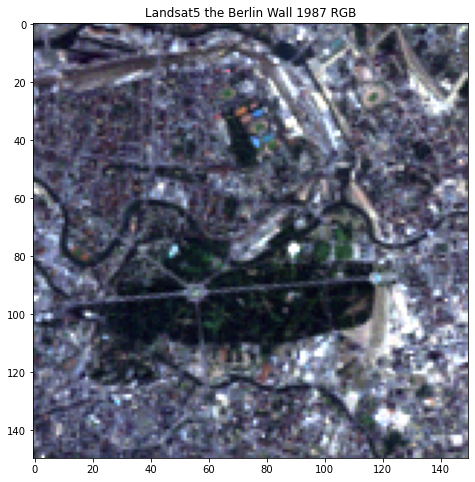

In [240]:
LS5_1987_s = stretch_im(LS5_1987, str_clip=1)

LS5_RGB =LS5_1987_s[:,600:750,650:800]
plt.figure(figsize=(8,8))
plt.imshow(np.moveaxis(LS5_RGB , 0, -1))
plt.title('Landsat5 the Berlin Wall 1987 RGB')
plt.savefig('LS5_1989_RGB_Berlin_wall.png', dpi=300)

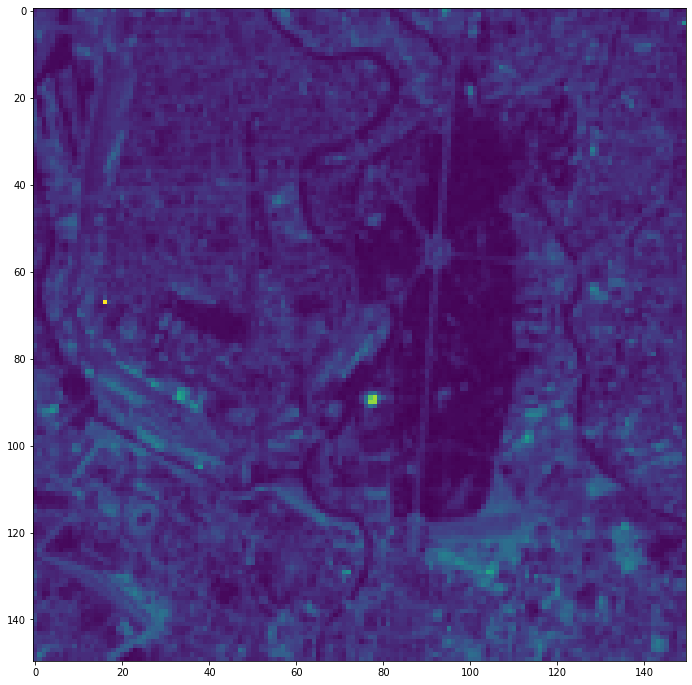

In [224]:
LS5_RGB =LS5_1987[0,600:750,650:800]
#LS5_RGB =LS5_1987[0,500:800,600:800]
plt.figure(figsize=(12, 12))
plt.imshow(np.moveaxis(LS5_RGB, 0, -1));

### Landsat 8

In [225]:
os.listdir('berlin_summer2019_LS8_gee_download/')

['LC08_L1TP_193023_20190726_20190801_01_T1_Berlin_B1.tif',
 'LC08_L1TP_193023_20190726_20190801_01_T1_Berlin_B10.tif',
 'LC08_L1TP_193023_20190726_20190801_01_T1_Berlin_B11.tif',
 'LC08_L1TP_193023_20190726_20190801_01_T1_Berlin_B2.tif',
 'LC08_L1TP_193023_20190726_20190801_01_T1_Berlin_B3.tif',
 'LC08_L1TP_193023_20190726_20190801_01_T1_Berlin_B4.tif',
 'LC08_L1TP_193023_20190726_20190801_01_T1_Berlin_B5.tif',
 'LC08_L1TP_193023_20190726_20190801_01_T1_Berlin_B6.tif',
 'LC08_L1TP_193023_20190726_20190801_01_T1_Berlin_B7.tif',
 'LS8_20190726_RGB.tif']

In [226]:
# Create a dictionary of band numbers and colors
# this helps us remember what band is what for Landsat 8!
bands = {'B4' : 'Red', 'B3' : 'Green', 'B2' : 'Blue'}

# MORE COMPACT file reading with list comprehension
files = [glob.glob('berlin_summer2019_LS8_gee_download/L*' + band + '.tif')[0] for band in bands]

with rio.open(files[0]) as src:
    metadata = src.meta

# Update meta to reflect the number of layers
metadata.update(count = len(files))

# Read each layer and write it to stack
with rio.open('berlin_summer2019_LS8_gee_download/LS8_20190726_RGB.tif', 'w', **metadata) as dst:
    for i in range(len(files)):
        file = files[i]
        with rio.open(file, 'r') as src:
            dst.write_band(i+1, src.read(1))

In [227]:
fn = 'berlin_summer2019_LS8_gee_download/LS8_20190726_RGB.tif'
with rio.open(fn, 'r') as file:
    LS8_2019 = file.read()
    LS8_2019_metadata = file.meta
    file.close

Text(0.5, 1.0, 'Landsat8 Berlin 2019 RGB')

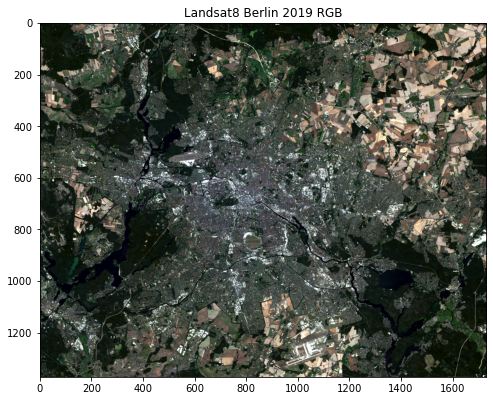

In [228]:
LS8_2019_s = stretch_im(LS8_2019, str_clip=1)

plt.figure(figsize=(8,8))
plt.imshow(np.moveaxis(LS8_2019_s, 0, -1))
plt.title('Landsat8 Berlin 2019 RGB')
#plt.savefig('figures/NB10_fig02_LS8_2019_RGB_Berlin.png', dpi=300)

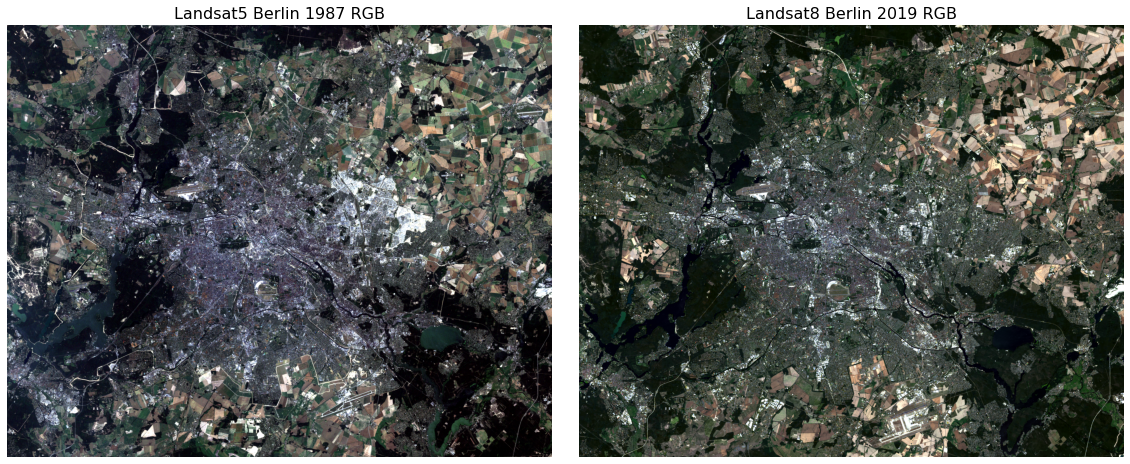

In [231]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,12), gridspec_kw={'wspace' : 0.05})

ax1.imshow(np.moveaxis(LS5_1987_s, 0, -1))
ax1.axis('off')
ax1.set_title("Landsat5 Berlin 1987 RGB" , fontsize=16)

ax2.imshow(np.moveaxis(LS8_2019_s, 0, -1))
ax2.axis('off')
ax2.set_title("Landsat8 Berlin 2019 RGB" , fontsize=16)

#plt.savefig('figures-Exam/Part3-Task1_1989_2019_RGB_Berlin.png', dpi=300)

### Canny edge detector:

The <a href='https://scikit-image.org/docs/stable/auto_examples/edges/plot_canny.html'>**Canny edge detector**</a> is an edge detection operator that uses a multi-stage algorithm to detect a wide range of edges in images and this filter use both low- and high-pass filtering to find binary edges in an image.


- The first important step, is that the algorithm is based on grayscale pictures.
- Therefore, the pre-requisite is to convert the image to grayscale before following the rest of the steps.
- Initial smoothing with a Gaussian kernel (with a standard deviation sigma giving the width).
- Gradient measurement (using the Sobel kernels).
- The connecting of strong gradients to form continuous edges.

In [235]:
#LS5_RGB =LS5_1987[0,600:750,650:800]
LS5_RGB =LS5_1987[0,600:750,650:800]
#grayLS5= color.rgb2gray(np.moveaxis(LS5_RGB, 0, -1)) #to convert the image to grayscale
#extract just one band of the 3D RGB array using notation like [0, :, :], which means [first band, all rows, all columns]
grayLS5 = LS5_RGB[0,:,:] 

<ipython-input-235-bcb5d8894069>:3: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  grayLS5= color.rgb2gray(np.moveaxis(LS5_RGB, 0, -1))


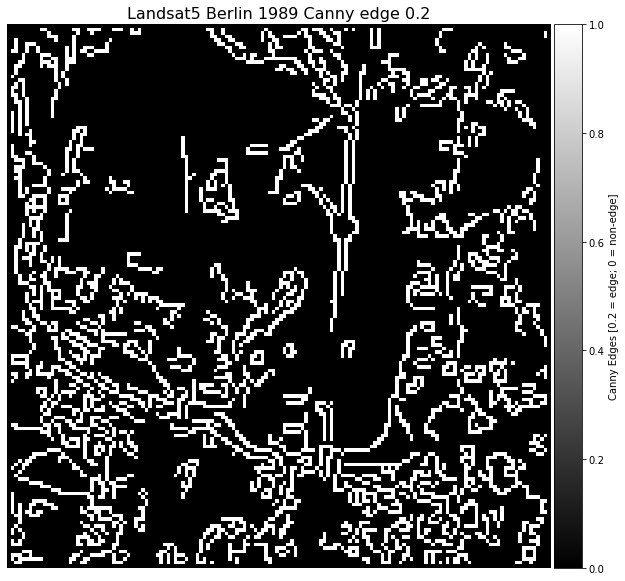

In [260]:
cannyLS5 = feature.canny(grayLS5, sigma= 0.2 )

fig, (ax1) = plt.subplots(1, 1, figsize=(16, 10))
im = ax1.imshow(cannyLS5, cmap='gray')
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im,cax=cax, label='Canny Edges [0.2 = edge; 0 = non-edge]')
ax1.axis('off')
ax1.set_title('Landsat5 Berlin 1989 Canny edge 0.2', fontsize=16)

#plt.savefig('The-Landsat5-1989-Berlin-Well_0.2.png', dpi=300)

In [243]:
LS8_RGB =LS8_2019[0,600:750,650:800]
#grayLS8 = color.rgb2gray(np.moveaxis(LS8_RGB, 0, -1))
grayLS8 = LS8_RGB[0,:,:] 

<ipython-input-243-af1abd11728e>:2: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  grayLS8 = color.rgb2gray(np.moveaxis(LS8_RGB, 0, -1))


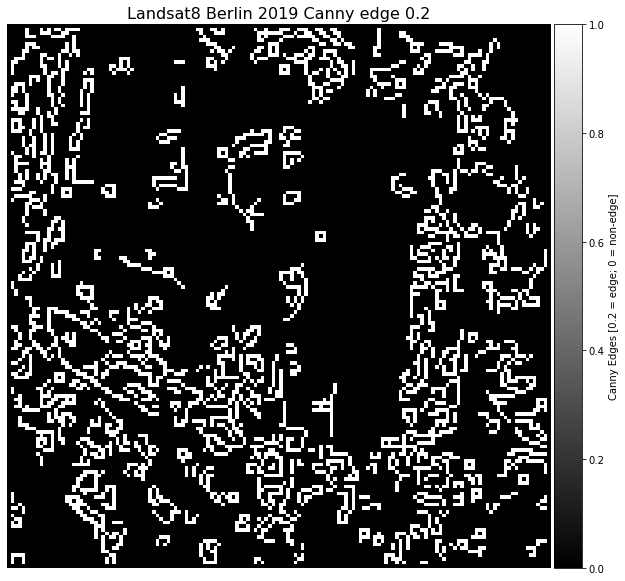

In [261]:
cannyLS8 = feature.canny(grayLS8, sigma= 0.2 )

fig, (ax1) = plt.subplots(1, 1, figsize=(16, 10))
im = ax1.imshow(cannyLS8, cmap='gray')
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im,cax=cax, label='Canny Edges [0.2 = edge; 0 = non-edge]')
ax1.axis('off')
ax1.set_title('Landsat8 Berlin 2019 Canny edge 0.2', fontsize=16 )

#plt.savefig('The-Landsat8-2019-Berlin-Well_0.2.png', dpi=300)

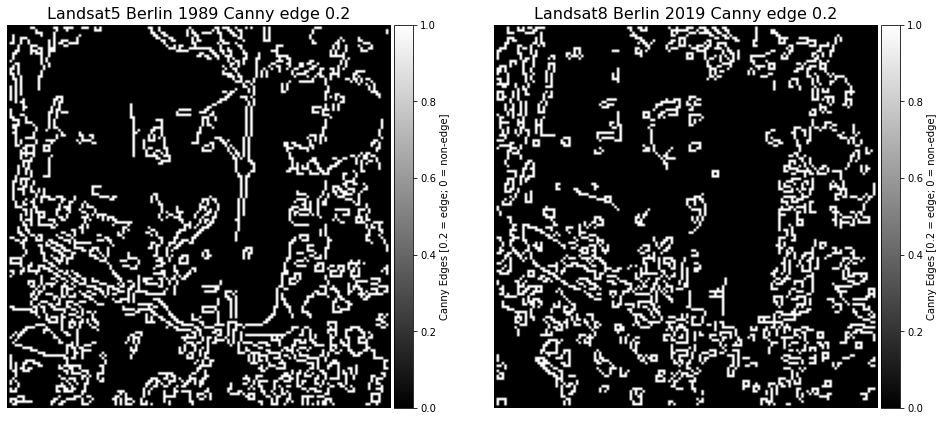

In [263]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))

im = ax1.imshow(cannyLS5, cmap='gray')
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im,cax=cax, label='Canny Edges [0.2 = edge; 0 = non-edge]')
ax1.axis('off')
ax1.set_title('Landsat5 Berlin 1989 Canny edge 0.2', fontsize=16 )


im = ax2.imshow(cannyLS8, cmap='gray')
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im,cax=cax, label='Canny Edges [0.2 = edge; 0 = non-edge]')
ax2.axis('off')
ax2.set_title('Landsat8 Berlin 2019 Canny edge 0.2', fontsize=16 )
#plt.savefig('The Berlin-Well_1989_2019.png', dpi=300)

* From the comparison between the landsat5 1989 and the Landasat8 2019 with the same sigma = 0.2, Berlin Wall was presented clearly in 1989, but this doesn’t exist in Landasat8 2019.

* This is in general due to the fall of the Berlin Wall in 1989.